In [14]:
#Imports
import numpy as np
import networkx as nx
import utils.NNetwork as nn
import utils.ndl as ndl
from utils.ndl import Network_Reconstructor
from helper_functions.helper_functions import display_denoising_stats_list_plot, Generate_corrupt_graph, compute_ROC_AUC_colored, rocch, calculate_AUC
from helper_functions.NDR_denoising_helper import run_NDR_denoising
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics, model_selection
from tqdm import trange
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from pathlib import Path
import pandas as pd

In [15]:

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    #"font.size"   : 15,
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})

# Caltech+ER denoising plot from saved file

In [16]:
directory_network_files = "Data/Networks_all_NDL/"
save_folder = "Network_dictionary/test"
ntwk = 'COVID_PPI.txt'
#ntwk = 'Caltech36.txt'
path = directory_network_files + "/" + str(ntwk)
network_name = ntwk.replace('.txt', '')
network_name = network_name.replace('.', '')

k = 20  # list of number of nodes in the chain motif -- scale parameter
n_components = 25  # number of latent motifs to be learned)
noise_type = "WS"
noise_density = 0.5
sampling_alg = 'pivot'

G = nn.NNetwork()
G.load_add_wtd_edges(path, increment_weights=False, use_genfromtxt=True)
print('!!!', G.get_edges()[0])
print('num edges in G', len(G.edges))
print('num nodes in G', len(G.nodes()))

reconstructor = ndl.Network_Reconstructor(G=G,  # networkx simple graph
                                      n_components=n_components,  # num of dictionaries
                                      MCMC_iterations=10,
                                      # MCMC steps (macro, grow with size of ntwk)
                                      sample_size=1000,  # number of patches in a single batch
                                      batch_size=10,
                                      # number of columns used to train dictionary
                                      # within a single batch step (keep it)
                                      sub_iterations=10,  # number of iterations of the
                                      # sub-batch learning (keep it)
                                      k1=0, k2=k - 1,  # left and right arm lengths
                                      if_wtd_network=True,
                                      sampling_alg = sampling_alg,
                                      # keep false to use Pivot chain for recons.
                                      # whether use i.i.d. subsampling for each batch
                                      omit_folded_edges=False,
                                      Pivot_exact_MH_rule=False)

reconstructor.result_dict.update({'Network name': network_name})
reconstructor.result_dict.update({'# of nodes': len(G.vertices)})

!!! ['107777', '110308']
num edges in G 4911
num nodes in G 1555


In [17]:
# Compute performance metrics 

noise_sign = "added"
noise_type = "ER"
# load original network 
ntwk = 'Caltech36.txt'
path = "Data/Networks_all_NDL" + "/" + str(ntwk)
save_folder = "Network_dictionary/test1"
network_name = ntwk.replace('.txt', '')
network_name = network_name.replace('.', '')

G = nn.NNetwork()
G.load_add_wtd_edges(path, increment_weights=False, use_genfromtxt=True)
print('num edges in G', len(G.get_edges()))
print('num nodes in G', len(G.nodes()))

# load corrupted network
path_corrupt="Network_dictionary/denoising_data/Caltech36_noise_nodes_769_noisetype_ER_edges_n_edges_added_7811.txt"
#G_corrupt_edges = np.genfromtxt(path_corrupt, delimiter=',')
#G_corrupt = nn.NNetwork()
#G_corrupt.add_edges(G_corrupt_edges)
#print('num edges in G_corrupt', len(G_corrupt.get_edges()))
#print('num nodes in G_corrupt', len(G_corrupt.nodes()))

# load colored reconstruction
path="Network_dictionary/denoising_data/full_result_Caltech36_Use_corrupt_dict_True_769_n_corrupt_edges_7811_noisetype_ER_edges.npy"
result_dict = np.load(path, allow_pickle=True).item()
recons_colored_edges = result_dict.get("Colored edges in reconstruction")

#path = "Network_dictionary/NDL_rev1/Network_dict_Caltech36_20_n_corrupt_edges_7854_25_noisetype_ER_edges_wtd_edgelist_recons.pickle"
#recons_colored_edges = np.load(path, allow_pickle=True)

ROC_file_name = network_name + "\n" + "ER_" + "n_edges_" + noise_sign

ROC_dict_list = compute_ROC_AUC_colored(G_original=G,
                               #G_corrupted=G_corrupt,
                               path_corrupt=path_corrupt,
                               recons_colored_edges=recons_colored_edges,
                               #is_dict_edges=True,
                               delimiter_original=',',
                               delimiter_corrupt=',',
                               save_file_name=ROC_file_name,
                               save_folder=save_folder,
                               # flip_TF=not omit_chain_edges_denoising, (10/12/2021 for direct comparison of various methods)
                               flip_TF=False,
                               subtractive_noise=(noise_type == '-ER_edges'))

num edges in G 33312
num nodes in G 769
!!!! ROC computation begins..
num colored edges in G_recons 591361
num edges in G_original 33312
num edges in G_corrupted 48934
AUC with convex hull:  0.5006778140746595
AUC without convex hull:  0.2383782065508366
PR Accuracy without convex hull:  0.5225776399338645


/Users/hanbaek/Dropbox/PythonProjects/NDL_paper_rev/helper_functions/helper_functions.py:1235: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)


Training AUC:  0.235127117946823
Training threshold:  0.6320190185765286
Test confusion_mx: 
 [[0.10271772 0.89728228]
 [0.10137314 0.89862686]]
Test accuracy:  0.6445130175338211
Test precision:  nan
Test recall:  0.8981576134522171
Test F-score:  nan
AUC with convex hull:  0.6915259549412249
AUC without convex hull:  0.6898899779654775
PR Accuracy without convex hull:  0.8375050831459991
Training AUC:  0.6940212188709868
Training threshold:  0.44094355222757714
Test confusion_mx: 
 [[0.74408939 0.25591061]
 [0.48284218 0.51715782]]
Test accuracy:  0.5894592716720481
Test precision:  0.8132980970588024
Test recall:  0.5171691029134781
Test F-score:  0.6310299604677998
AUC with convex hull:  0.9098842736424461
AUC without convex hull:  0.9089080472937526
PR Accuracy without convex hull:  0.9513477135897842
Training AUC:  0.9079519357801564
Training threshold:  0.15742878533889054
Test confusion_mx: 
 [[0.82235662 0.17764338]
 [0.16574244 0.83425756]]
Test accuracy:  0.8304614378550701


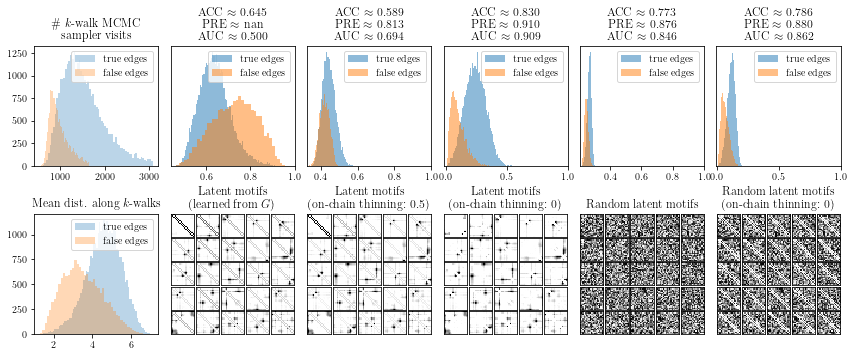

In [18]:
denoising_dict = result_dict.get("denoising_dict")
use_dict_from_corrupted_ntwk=True
At = result_dict.get("Code COV learned")
W_list_filtered = result_dict.get("W_list_filtered")

display_denoising_stats_list_plot(denoising_dict = denoising_dict,
                             At = At,
                             W_list_filtered = W_list_filtered,
                             ROC_dict_list = ROC_dict_list,
                             save_path = "Network_dictionary/test1/denoising_caltech_comparison",
                             title = "test",
                             fig_size = [14,5])

# Caltech+ER denoising plot from from scratch

In [3]:
ntwk = 'Caltech36.txt'
path = "Data/Networks_all_NDL" + "/" + str(ntwk)
save_folder = "Network_dictionary/test1"
network_name = ntwk.replace('.txt', '')
network_name = network_name.replace('.', '')

G = nn.NNetwork()
G.load_add_wtd_edges(path, increment_weights=False, use_genfromtxt=True)
print('num edges in G', len(G.get_edges()))
print('num nodes in G', len(G.nodes()))

k=20

# Generate Corrupted network 
n_edges = len(nx.Graph(G.edges).edges)

path_original = path
save_folder = "Network_dictionary/test1"

noise_nodes = len(G.vertices)
noise_type = 'ER'
parameter = 0.5
path_save = save_folder + "/" + network_name + "_noise_nodes_" + str(
    noise_nodes) + "_noisetype_" + noise_type

noise_sign = "added"
if noise_type == '-ER_edges':
    noise_sign = "deleted"
G_corrupt, edges_changed = Generate_corrupt_graph(path_load=path_original,
                                                  delimiter=' ',
                                                  G_original=G,
                                                  path_save=path_save,
                                                  noise_nodes=noise_nodes,
                                                  parameter=parameter,
                                                  noise_type=noise_type)
path_corrupt = path_save + ".txt"

print('Corrupted network generated with %i edges ' % len(edges_changed) + noise_sign)
print('path_corrupt', path_corrupt)

num edges in G 33312
num nodes in G 769
edges added = 7837
num undirected edges right after corruption: 24493
Corrupted network generated with 7837 edges added
path_corrupt Network_dictionary/test1/Caltech36_noise_nodes_769_noisetype_ER.txt


In [5]:
# Learn dictionary from corrupted (observed) network
reconstructor_corrupt = Network_Reconstructor(G=G_corrupt,  # NNetwork simple graph
                                          n_components=25,  # num of dictionaries
                                          MCMC_iterations=5,
                                          # MCMC steps (macro, grow with size of ntwk)
                                          sample_size=1000,
                                          # number of patches in a single batch
                                          batch_size=100,
                                          # number of columns used to train dictionary
                                          # within a single batch step (keep it)
                                          sub_iterations=10,
                                          # number of iterations of the
                                          # sub-batch learning (keep it)
                                          k1=0, k2=k,  # left and right arm lengths
                                          if_wtd_network=True,
                                          sampling_alg = 'pivot',
                                          ONMF_subsample=True,
                                          Pivot_exact_MH_rule=False)
### Set up network dictionary
reconstructor_corrupt.W = reconstructor_corrupt.train_dict(update_dict_save=True,
                                                            skip_folded_hom=True)



### Denoising
W_corrupt = reconstructor_corrupt.W
W_rand = np.random.rand(W_corrupt.shape[0], W_corrupt.shape[1])
W_list = [W_corrupt] * 3 + [W_rand] * 2

recons_iter = 5*int(len(G.vertices) * np.log(len(G.vertices)))

G_recons = reconstructor_corrupt.reconstruct_network_list(W_list = W_list,
                                                        recons_iter=5000, ### Increase this to 100000 to get reported performance
                                                        jump_every=1000,
                                                        if_save_history=True,
                                                        ckpt_epoch=50000,
                                                        masking_params_list=[1, 0.5, 0, 1, 0],
                                                        #masking_params_list=[0],
                                                        edges_added=edges_changed,
                                                        #save_path = save_folder + "/" + save_filename,
                                                        if_keep_visit_statistics=True)


training dictionaries from patches...
skip_folded_hom= True
W.shape (441, 25)


  0%|                                                     | 0/5 [00:00<?, ?it/s]

homomorphism resampled


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.89s/it]


!!!number of distinct nodes in homomorhpisms : avg 21.0 std 0.000
reconstructing given network...
!!! sampling alg =  pivot
!!! masking_params_list =  [1, 0.5, 0, 1, 0]
masking_params_list applied: 1
masking_params_list applied: 0.5
masking_params_list applied: 0
masking_params_list applied: 1
masking_params_list applied: 0


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

homomorphism resampled during reconstruction
# edges of original ntwk= 48986
# edges of reconstructed ntwk= 40
Jaccard reconstruction accuracy= 0.0008165598334217939


  0%|                                        | 3/5000 [00:12<4:22:10,  3.15s/it]

memory use: 0.59051513671875


 20%|███████▊                               | 1003/5000 [01:20<04:43, 14.10it/s]

homomorphism resampled during reconstruction


 40%|███████████████▌                       | 2001/5000 [02:45<04:43, 10.60it/s]

homomorphism resampled during reconstruction


 60%|███████████████████████▍               | 3001/5000 [04:25<03:35,  9.28it/s]

homomorphism resampled during reconstruction


 80%|███████████████████████████████▏       | 4001/5000 [06:20<02:02,  8.15it/s]

homomorphism resampled during reconstruction


100%|███████████████████████████████████████| 5000/5000 [08:25<00:00,  9.89it/s]


!!! num edges in G_recons 502377
!!! num edges in G_overlap_count 502377
!!! num colored edges in G_overlap_count 502377
!!! n_false_edges 15674
!!! n_true_edges 33312
!!! max visits to false edges 28
!!! max visits to true edges 50
# of false edges ever reconstructed= 15636 out of 15674
ratio of false edges ever reconstructed= 0.9975756029092765
avg reconstructed weight of false edges 0.9975756029092765
avg reconstructed weight of true edges 0.6796635773486303
avg_n_visits2false_edge 14.714048743141507
avg_n_visits2true_edge 15.584697668721676
Reconstructed in 516.49 seconds
Number of edges in the baseline recons. :  48096


In [7]:
# Compute performance metrics 

recons_colored_edges = reconstructor_corrupt.result_dict.get('Colored edges in reconstruction')

ROC_file_name = network_name + "\n" + "WS_" + str(noise_nodes) + "_p_" + str(parameter).replace(
        '.',
        '') + "_n_edges_" + noise_sign + "_" + str(
        len(edges_changed)) + "_iter_" + str(iter)

ROC_dict_list = compute_ROC_AUC_colored(G_original=G,
                               #path_corrupt=path_corrupt,
                               G_corrupted = G_corrupt,
                               recons_colored_edges=recons_colored_edges,
                               #is_dict_edges=True,
                               delimiter_original=',',
                               delimiter_corrupt=',',
                               save_file_name=ROC_file_name,
                               save_folder=save_folder,
                               # flip_TF=not omit_chain_edges_denoising, (10/12/2021 for direct comparison of various methods)
                               flip_TF=False,
                               subtractive_noise=(noise_type == '-ER_edges'))

!!!! ROC computation begins..
num colored edges in G_recons 502377
num edges in G_original 33312
num edges in G_corrupted 48986
AUC with convex hull:  0.5043213962057916
AUC without convex hull:  0.28347372981093544
PR Accuracy without convex hull:  0.5473310792516023
Training AUC:  0.2831253707895162
Training threshold:  0.16747737882012198
Test confusion_mx: 
 [[0.01135565 0.98864435]
 [0.00399657 0.99600343]]
Test accuracy:  0.6812803658188054
Test precision:  0.6819802908844766
Test recall:  0.9960035632854091
Test F-score:  0.809607036278057
AUC with convex hull:  0.5346558419804394
AUC without convex hull:  0.5225163734621353
PR Accuracy without convex hull:  0.6762668372750545
Training AUC:  0.5194268363231793
Training threshold:  0.2090775047771468
Test confusion_mx: 
 [[0.23702579 0.76297421]
 [0.17660585 0.82339415]]
Test accuracy:  0.635781651900543
Test precision:  0.6963906791890956
Test recall:  0.8233928569004695
Test F-score:  0.7545819146761141
AUC with convex hull:  0

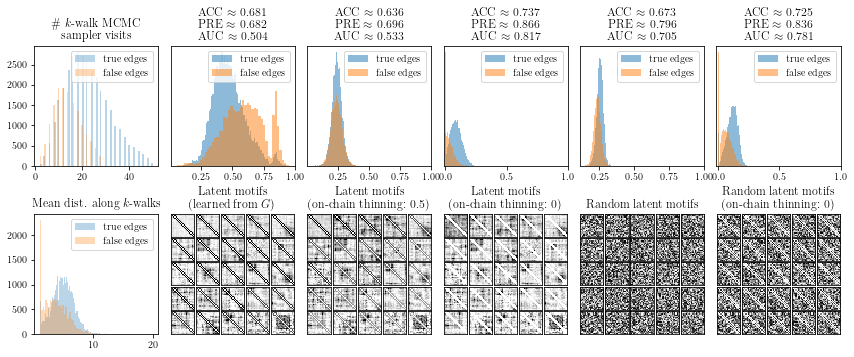

In [13]:
denoising_dict = reconstructor_corrupt.result_dict.get("denoising_dict")
use_dict_from_corrupted_ntwk=True
At = reconstructor_corrupt.result_dict.get("Code COV learned")
W_list_filtered = reconstructor_corrupt.result_dict.get("W_list_filtered")

display_denoising_stats_list_plot(denoising_dict = denoising_dict,
                             At = At,
                             W_list_filtered = W_list_filtered,
                             ROC_dict_list = ROC_dict_list,
                             save_path = "Network_dictionary/test1/denoising_caltech_comparison",
                             title = "test",
                             fig_size = [14,5])